In [179]:
import os 
import PIL
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Verify tensorflow is using GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("GPU not found, check and run 'export LD_LIBRARY_PATH=\"/usr/local/cuda-11.0/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}\"'")

Default GPU Device:/device:GPU:0


2021-12-21 20:15:57.835138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 20:15:57.835541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 20:15:57.835834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 20:15:57.836249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 20:15:57.836614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
# Directories
base_dir = './Land-Use_Scene/'
train_dir = './Land-Use_Scene/images_train_test_val/train'
test_dir = './Land-Use_Scene/images_train_test_val/test'
val_dir = './Land-Use_Scene/images_train_test_val/validation'

In [ ]:
# Read files
def data_generator(SOURCE_DIR, train=False):
    if train:
        data_gen = ImageDataGenerator(
            rescale=1./255, 
            rotation_range=40, 
            width_shift_range=0.20,
            height_shift_range=0.20,
#             zoom_range=0.20,
            fill_mode='nearest',
            horizontal_flip=True,
            vertical_flip=True,
        )
    else:
        data_gen = ImageDataGenerator(rescale=1./255)
        
    data_generator = data_gen.flow_from_directory(
        SOURCE_DIR,
        target_size=(256, 256),
        batch_size=256,
        class_mode='categorical'
    )
    
    return data_generator


train_generator = data_generator(train_dir, train=True)
validation_generator = data_generator(val_dir)
test_generator = data_generator(test_dir)

In [209]:
# Build model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.9),
    
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(21, activation='softmax')
    
])

# Define callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, model, log={}):
        if log.get("accuracy") is not None and log.get("accuracy") >= 0.99:
            self.model.stop_training=True
            print("Model reached desired training accuracy")
        if len(self.model.history.history) != 0:
            try:
                last_three_accs = sum(self.model.history.history['val_accuracy'][0:-10]) / 10
                if log['val_accuracy'] < last_three_accs:
                    self.model.stop_training=True
                    print("Model overfitting, stopping training")

            except IndexError:
                pass
            
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_410 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_239 (MaxPoolin (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_412 (Conv2D)          (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_413 (Conv2D)          (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_240 (MaxPoolin (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 59, 59, 128)     

In [210]:
history = model.fit(
    train_generator, 
    epochs=50, 
    validation_data=validation_generator,
    verbose=1,
    callbacks=[myCallback()],
)

Epoch 1/200
230/230 [==============================] - 23s 96ms/step - loss: 3.3097 - accuracy: 0.0601 - val_loss: 3.0036 - val_accuracy: 0.0762
Epoch 2/200
230/230 [==============================] - 22s 96ms/step - loss: 2.9560 - accuracy: 0.1099 - val_loss: 2.7699 - val_accuracy: 0.1319
Epoch 3/200
230/230 [==============================] - 22s 95ms/step - loss: 2.5918 - accuracy: 0.1841 - val_loss: 2.2846 - val_accuracy: 0.2614
Epoch 4/200
230/230 [==============================] - 22s 97ms/step - loss: 2.2737 - accuracy: 0.2810 - val_loss: 1.9704 - val_accuracy: 0.4043
Epoch 5/200
230/230 [==============================] - 22s 96ms/step - loss: 1.9623 - accuracy: 0.3741 - val_loss: 1.7872 - val_accuracy: 0.4100
Epoch 6/200
230/230 [==============================] - 22s 96ms/step - loss: 1.7072 - accuracy: 0.4576 - val_loss: 1.8490 - val_accuracy: 0.4100
Epoch 7/200
230/230 [==============================] - 22s 96ms/step - loss: 1.5152 - accuracy: 0.5261 - val_loss: 1.2456 - val_ac

KeyboardInterrupt: 

In [194]:
model.evaluate(test_generator)

33/33 [==============================] - 2s 65ms/step - loss: 1.3066 - accuracy: 0.6829


[1.306597352027893, 0.6828571557998657]

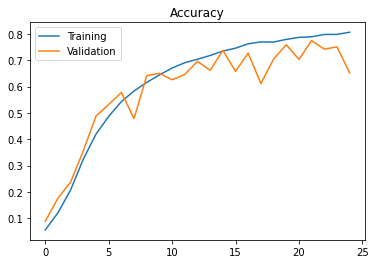

In [190]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.title("Loss")
plt.show()

/tmp/ipykernel_17352/3034309455.py:58: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


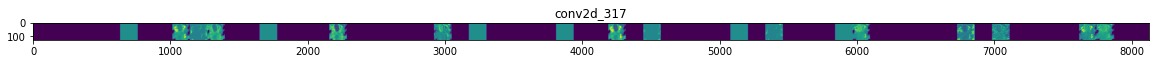

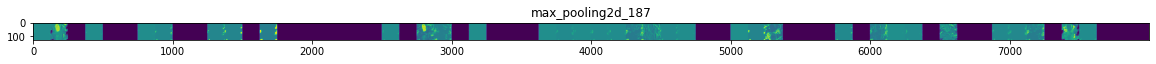

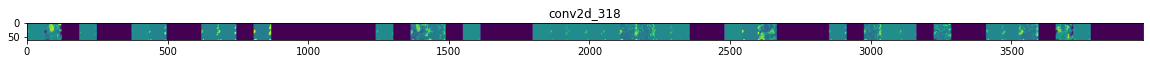

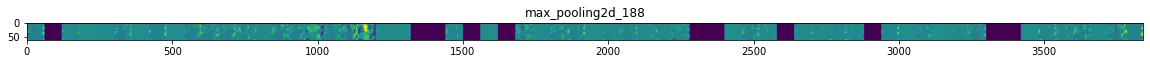

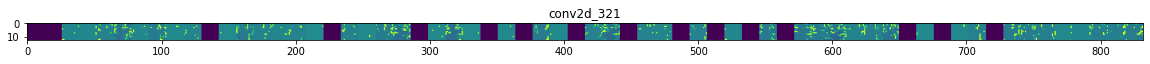

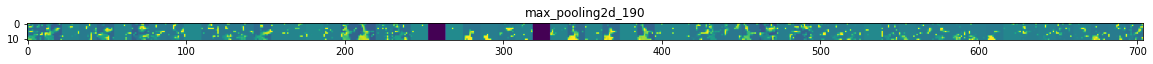

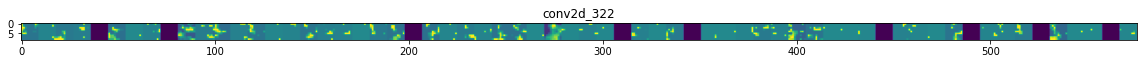

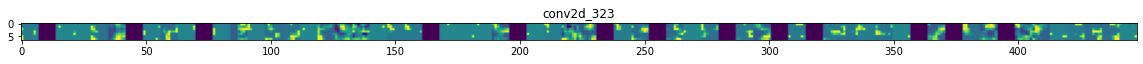

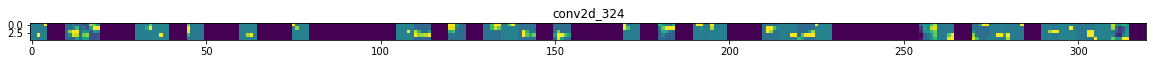

In [165]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
def show_filters(item):
    # Let's define a new Model that will take an image as input, and will output
    # intermediate representations for all layers in the previous model after
    # the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]

    #visualization_model = Model(img_input, successive_outputs)
    visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

    airplane_images = [os.path.join(test_dir + "/{}/".format(item), fname) for fname in os.listdir(os.path.join(test_dir, item))]

    # Let's prepare a random input image of a cat or dog from the training set.

    # cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
    # dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

    img_path = random.choice(airplane_images)
    img = load_img(img_path, target_size=(256, 256))  # this is a PIL image

    x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
    x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

    # Rescale by 1/255
    x /= 255.0

    # Let's run our image through our network, thus obtaining all
    # intermediate representations for this image.
    successive_feature_maps = visualization_model.predict(x)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers]

    # -----------------------------------------------------------------------
    # Now let's display our representations
    # -----------------------------------------------------------------------
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):

      if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
          x  = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
        
show_filters('golfcourse')

# Transfer learning

In [239]:
# Load VGG16 model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [245]:
vgg_model = VGG16(include_top=False, input_shape=(256, 256, 3))
inception_model = InceptionV3(include_top=False, input_shape=(256, 256, 3))
model = vgg_model

# Set conv layers to untrainable 
for layer in model.layers:
    layer.trainable = False
    
# Get output of last layer 
last_output = model.layers[-1].output

In [247]:
# Add layers to model 
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(21, activation='softmax')(x)

# Define and compile model 
pre_model = tf.keras.models.Model(model.input, x)

print(pre_model.summary())

pre_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [248]:
history = pre_model.fit(
    train_generator, 
    epochs=200, 
    validation_data=validation_generator,
    verbose=1,
    callbacks=[myCallback()],
)

Epoch 1/200
230/230 [==============================] - 21s 88ms/step - loss: 2.4130 - accuracy: 0.3371 - val_loss: 1.1287 - val_accuracy: 0.6433
Epoch 2/200
230/230 [==============================] - 21s 89ms/step - loss: 1.5635 - accuracy: 0.4774 - val_loss: 1.0358 - val_accuracy: 0.6400
Epoch 3/200
230/230 [==============================] - 21s 90ms/step - loss: 1.4440 - accuracy: 0.5120 - val_loss: 0.9705 - val_accuracy: 0.6924
Epoch 4/200
230/230 [==============================] - 21s 89ms/step - loss: 1.3012 - accuracy: 0.5614 - val_loss: 0.7725 - val_accuracy: 0.7695
Epoch 5/200
230/230 [==============================] - 21s 90ms/step - loss: 1.2619 - accuracy: 0.5725 - val_loss: 0.7758 - val_accuracy: 0.7914
Epoch 6/200
230/230 [==============================] - 21s 90ms/step - loss: 1.1522 - accuracy: 0.6046 - val_loss: 0.7387 - val_accuracy: 0.7843
Epoch 7/200
230/230 [==============================] - 21s 90ms/step - loss: 1.0838 - accuracy: 0.6348 - val_loss: 0.6722 - val_ac

In [249]:
pre_model.evaluate(test_generator)

33/33 [==============================] - 2s 64ms/step - loss: 0.5148 - accuracy: 0.8514


[0.5147594213485718, 0.8514285683631897]

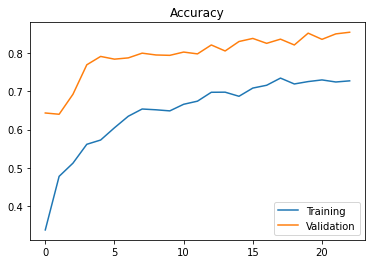

In [250]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.title("Loss")
plt.show()

/tmp/ipykernel_17352/781888814.py:55: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


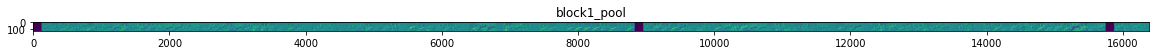

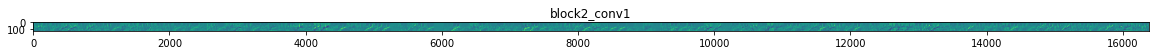

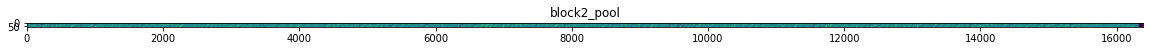

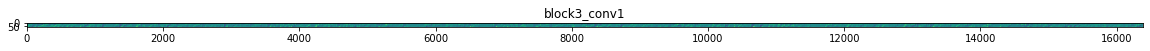

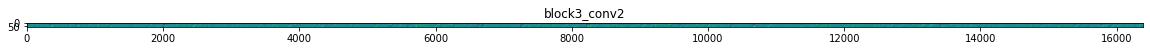

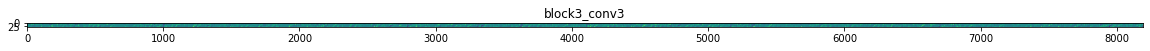

In [255]:
def show_filters(item):
    # Let's define a new Model that will take an image as input, and will output
    # intermediate representations for all layers in the previous model after
    # the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]

    #visualization_model = Model(img_input, successive_outputs)
    visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

    airplane_images = [os.path.join(test_dir + "/{}/".format(item), fname) for fname in os.listdir(os.path.join(test_dir, item))]

    # Let's prepare a random input image of a cat or dog from the training set.

    # cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
    # dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

    img_path = random.choice(airplane_images)
    img = load_img(img_path, target_size=(256, 256))  # this is a PIL image

    x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
    x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

    # Rescale by 1/255
    x /= 255.0

    # Let's run our image through our network, thus obtaining all
    # intermediate representations for this image.
    successive_feature_maps = visualization_model.predict(x)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers]

    # -----------------------------------------------------------------------
    # Now let's display our representations
    # -----------------------------------------------------------------------
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):

      if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
          x  = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std ()
          x *=  64
          x += 128
          x  = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
        
show_filters('airplane')